In [96]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,mean, count
from pyspark.sql.types import *

In [97]:
data_path = "./data/"
review_file_mapping = {"giftcards":"amazon_reviews_us_Gift_Card_v1_00.tsv"}

spark = SparkSession.builder \
    .appName("Analyse Reviews") \
    .getOrCreate()

In [98]:
schema = StructType([
    StructField("marketplace", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", IntegerType(), True),
    StructField("helpful_votes", IntegerType(), True),
    StructField("total_votes", IntegerType(), True),
    StructField("vine", BooleanType(), True),
    StructField("verified_purchase", BooleanType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", StringType(), True)
])

file_path = data_path + review_file_mapping["giftcards"]
df = spark.read.csv(file_path, schema=schema, sep="\t", header=True)

In [99]:
df.describe().show()

+-------+-----------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+--------------------+--------------------+-----------+
|summary|marketplace|         customer_id|     review_id|product_id|      product_parent|       product_title|product_category|       star_rating|      helpful_votes|       total_votes|     review_headline|         review_body|review_date|
+-------+-----------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+--------------------+--------------------+-----------+
|  count|     149086|              149086|        149086|    149086|              149086|              149086|          149086|            149086|             149086|            149086|              149086|              149080|     149081|
|   mean|       NULL| 2.628253678963149E

In [100]:
avg_star_rating = df.select(mean(col("star_rating"))).show()

reviews_per_category = df.groupBy("product_category").count().show()

avg_helpful_votes_per_rating = df.groupBy("star_rating").agg(mean(col("helpful_votes"))).show()

+-----------------+
| avg(star_rating)|
+-----------------+
|4.731363105858364|
+-----------------+

+----------------+------+
|product_category| count|
+----------------+------+
|       Gift Card|149086|
+----------------+------+

+-----------+-------------------+
|star_rating| avg(helpful_votes)|
+-----------+-------------------+
|          1|  6.341331107865638|
|          3| 1.0788973384030418|
|          5|0.11094064405708162|
|          4|  0.412922203063191|
|          2|  4.377310388782664|
+-----------+-------------------+



<Figure size 1200x600 with 0 Axes>

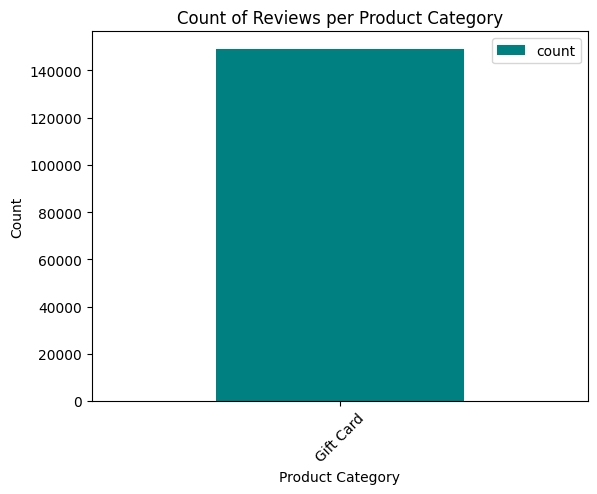

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.toPandas()
pdf_reviews_per_category = df.groupBy("product_category").count().toPandas()

plt.figure(figsize=(12, 6))
pdf_reviews_per_category.plot(kind='bar', x='product_category', y='count', color='teal')
plt.title('Count of Reviews per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

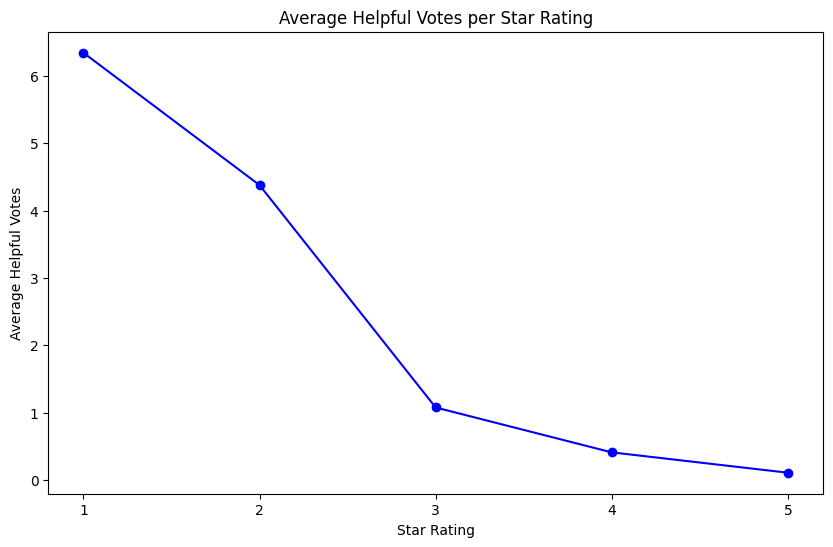

In [102]:
pdf_avg_helpful_votes_per_rating = df.groupBy("star_rating")\
                                     .agg(mean(col("helpful_votes")))\
                                     .orderBy("star_rating")\
                                     .toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pdf_avg_helpful_votes_per_rating['star_rating'], pdf_avg_helpful_votes_per_rating['avg(helpful_votes)'], marker='o', color='blue')
plt.title('Average Helpful Votes per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')
plt.xticks(range(1, 6))
plt.show()

In [103]:
from pyspark.sql.functions import sum as _sum

df_with_helpful_flag = df.withColumn("is_helpful", (col("helpful_votes") > 0).cast("integer"))

helpful_percentage_per_rating = df_with_helpful_flag.groupBy("star_rating").agg(
    (_sum("is_helpful") / count("*") * 100).alias("helpful_percentage")
).orderBy("star_rating")

helpful_percentage_per_rating.show()

+-----------+------------------+
|star_rating|helpful_percentage|
+-----------+------------------+
|          1|30.940955560191945|
|          2|  24.8565965583174|
|          3| 12.70595690747782|
|          4|5.9235216553402985|
|          5| 2.102398445751644|
+-----------+------------------+



<Figure size 1000x600 with 0 Axes>

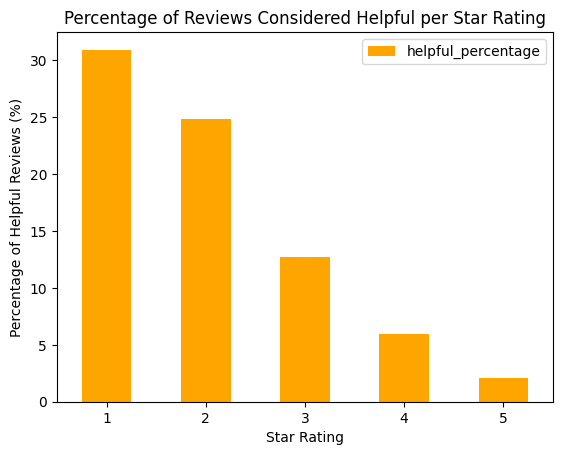

In [104]:
pdf_helpful_percentage = helpful_percentage_per_rating.toPandas()

plt.figure(figsize=(10, 6))
pdf_helpful_percentage.plot(kind='bar', x='star_rating', y='helpful_percentage', color='orange')
plt.title('Percentage of Reviews Considered Helpful per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Percentage of Helpful Reviews (%)')
plt.xticks(rotation=0)
plt.show()

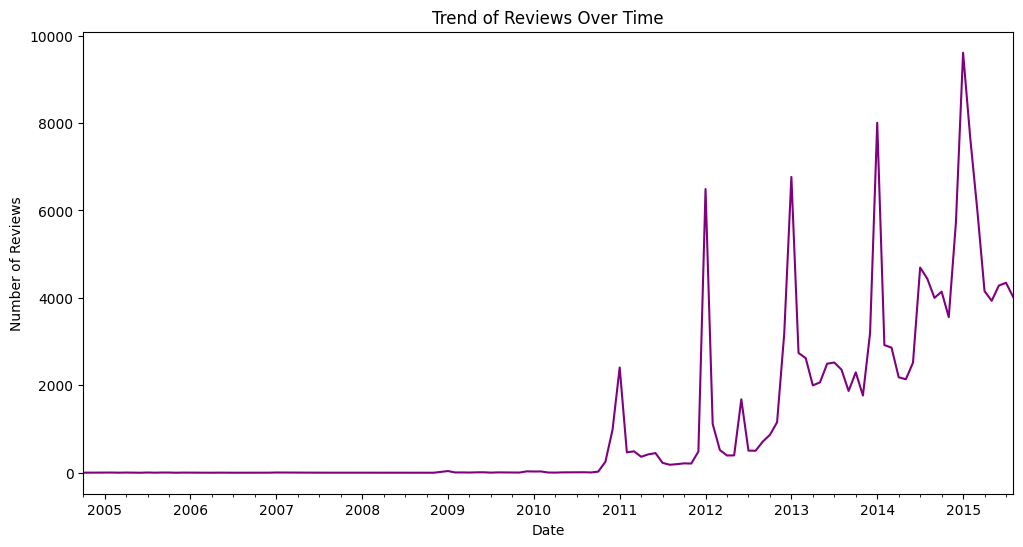

In [105]:
pdf['review_date'] = pd.to_datetime(pdf['review_date'], errors='coerce', format='%Y-%m-%d')

# Drop rows where review_date is NaT (Not a Time) due to conversion errors
pdf = pdf.dropna(subset=['review_date'])

pdf.set_index('review_date', inplace=True)

monthly_reviews = pdf.resample('M').size()

plt.figure(figsize=(12, 6))
monthly_reviews.plot(color='purple')
plt.title('Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

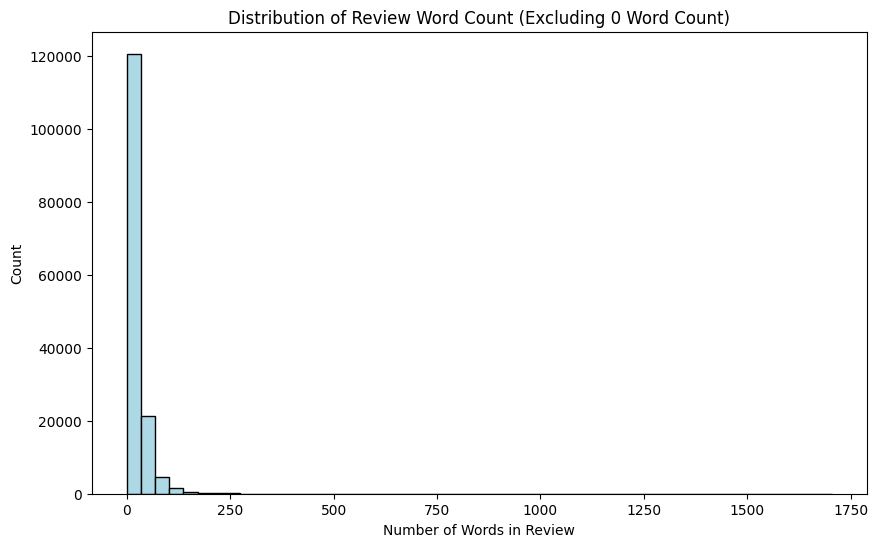

In [106]:
pdf['review_word_count'] = pdf['review_body'].str.split().apply(lambda x: len(x) if x is not None else 0)

filtered_pdf = pdf[pdf['review_word_count'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(filtered_pdf['review_word_count'], bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Review Word Count (Excluding 0 Word Count)')
plt.xlabel('Number of Words in Review')
plt.ylabel('Count')
plt.show()

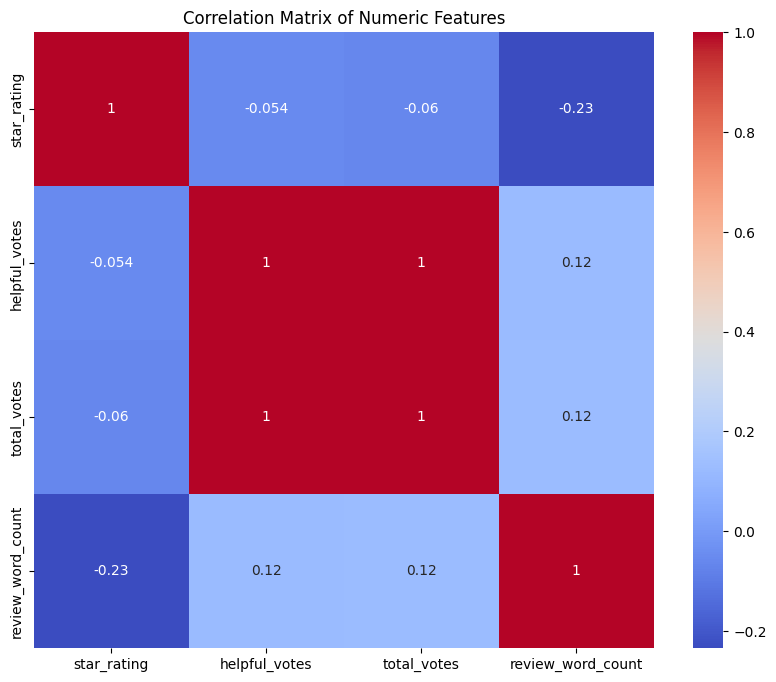

In [108]:
import seaborn as sns

corr_matrix = pdf[['star_rating', 'helpful_votes', 'total_votes', 'review_word_count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

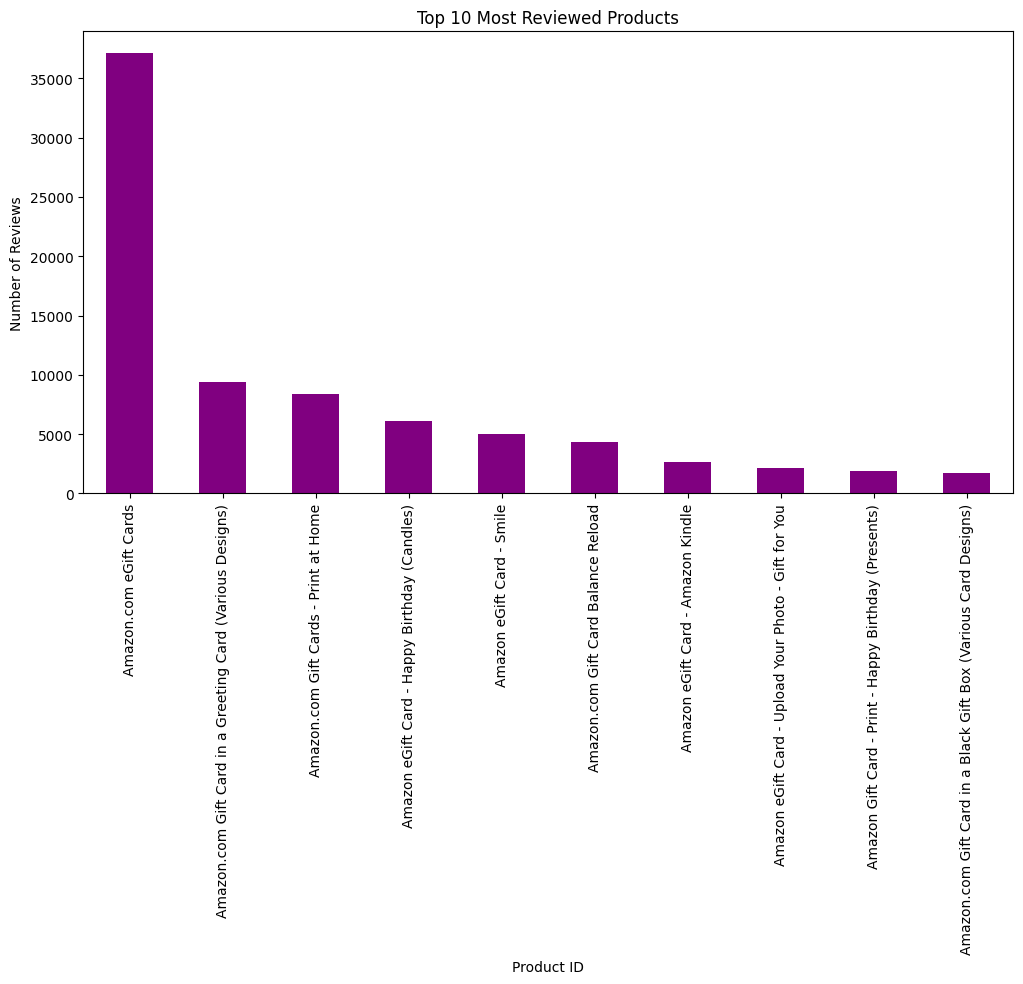

In [ ]:
reviews_per_product = pdf['product_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
reviews_per_product.plot(kind='bar', color='purple')
plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.show()

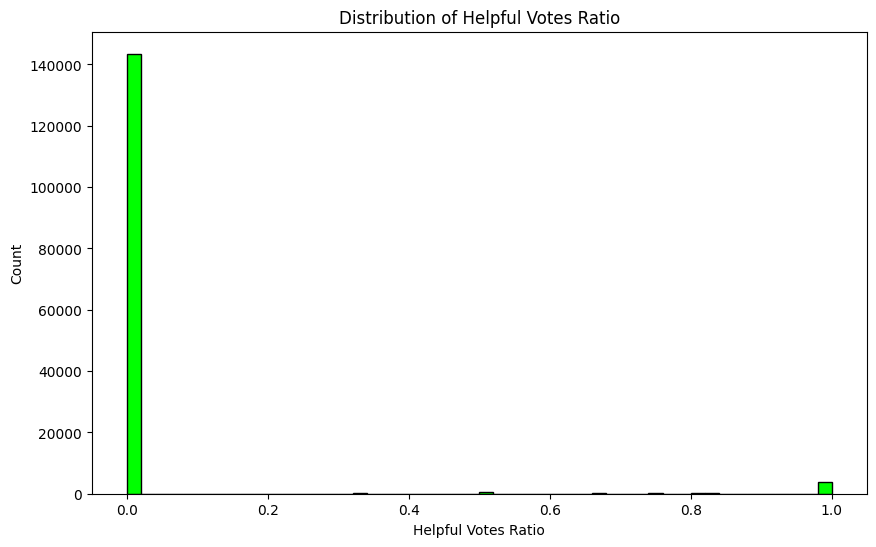

In [ ]:
pdf['helpful_ratio'] = pdf['helpful_votes'] / pdf['total_votes']
pdf['helpful_ratio'] = pdf['helpful_ratio'].fillna(0)

plt.figure(figsize=(10, 6))
plt.hist(pdf['helpful_ratio'], bins=50, color='lime', edgecolor='black')
plt.title('Distribution of Helpful Votes Ratio')
plt.xlabel('Helpful Votes Ratio')
plt.ylabel('Count')
plt.show()

In [111]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(text)['compound']

pdf['sentiment_score'] = pdf['review_body'].apply(get_sentiment)

pdf.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mihnea\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_word_count,sentiment_score
review_date,,,,,,,,,,,,,,,,
2015-08-31,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,None,None,Five Stars,Great birthday gift for a young adult.,7,0.7906
2015-08-31,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,None,None,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,19,0.8779
2015-08-31,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,None,None,Five Stars,Good,1,0.4404
2015-08-31,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,None,None,One Star,Fair,1,0.3182
2015-08-31,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,None,None,Five Stars,I can't believe how quickly Amazon can get the...,14,0.6219
